<a href="https://colab.research.google.com/github/SukhpreetKhangura/Task/blob/master/Task_3_RNN_Denoising_5_Sequences_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check the tensorflow version to avoid using any deprecated functions

In [0]:
import tensorflow as tf 
print(tf.__version__) 

2.2.0


Import all neceassry libraries

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,  MaxPooling2D, Embedding,Flatten, TimeDistributed, Dropout, RepeatVector, LSTM,BatchNormalization,Reshape,InputLayer,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import random
import shutil
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



## Obtain the Dataset:

1. To obtain the dataset we mount the google drive into colab
2. Create the Task directory in tmp if it doesnot exists
3. Copy the contents from the source directory(google drive) to the destination
4. Extract the contents from zipped random image folder

In [0]:
# Step 1
from google.colab import drive # Mount the Google Drive
drive.mount('/content/drive',force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Step 2

if not os.path.exists('/tmp/Task_Cinemo'):
     os.mkdir('/tmp/Task_Cinemo')    # Making directory of Task in tmp

In [0]:
# Step 3
!cp "/content/drive/My Drive/Task_Cinemo/src_images.zip" "/tmp/Task_Cinemo/src_images.zip" # copy the zipped random inages files

In [0]:
# Step 4
import zipfile     # Extracting Data from the zipped folder
zip_file = zipfile.ZipFile("/tmp/Task_Cinemo/src_images.zip", 'r')  
zip_file.extractall("/tmp")
zip_file.close()

Explore the source directory

In [0]:
source_dir="/tmp/src_images/random/"
print(len(os.listdir(source_dir)))
label_fnames = os.listdir( source_dir )
#print(label_fnames)

100


We have downloaded 100 random random images (photos) with medium resolution. Now, instead of using single patches we will be  using a sequence of five patches. So if we extract a sequence of 5 patches/image, we will have 500 images.

Since the performannce of Deep learning neural networks improves with the amount of data, to train only on 500 images will not be the wise choice. There could be three options:

1. Download more images from the web which could be time consuming
2. Use Data Augmentation (could be considered)
3. Increase the number of patches/image and generate a sequence (5) from these patches.

Here, we are following third approach and setting the number of patches per image by num_patches. Furthermore, we are generating a sequence of five using each patch. One is free to choose this parameter. However, secomd approach would have been more useful if we would have been dealing with image classification problem.

### Model Configuration

In [0]:
patch_size=(64,64) # Define patch size
img_width, img_height = patch_size
num_patches=15 # Define number of patches per image
seq_len=5 # a sequence five patches, i.e., each patch is replicated five times
noise_factor = 0.5# Defined  for Gaussian 



training_portion=.8
batch_size = 50
num_epochs = 100

1. Patch size  of 64x64 as we are extracting grayscale patches as per the requirement of the Task. Though it was asked to generate a patch of 256x256 but to save memory and computational cost, we adapted to 64x64 to show the basic schema.
2. The image width and  height  are set to according to patch size. 
3. As mentioned above, we have only dataset of 100 random images, therefore, in order to leverage the benefits of Deep learning performance, we are setting number of patches extracted per image by num_patches.
4. seq_len=5 , to replicate each patch five times. The Gaussian noise is generated and added to each of these sequence indedpendently.
5. The noise_factor represents the percentage of the generated noise that is added to the original patches.
6. Training portion defines the split of training and test data set.
7.  We use mini-batch gradient descent as it outperforms either gradient descent or stochastic gradient descent and set the batch_size to have  a balance between accurate gradients (during optimization) and speed of learning/memory requirements

In [0]:
fnames=[]
for names in label_fnames:
  for i in range(num_patches*seq_len):
    fnames.append(names)
print(len(fnames))

7500


Model Configuration

## Preprocessing functions



1. GrayScale Conversion
2. Random Patch Extraction 

*   Generating five sequences of extracted patch


3. Normalization of Images

In [0]:
def grayscale_patches(src_dir, patch_size, num_patches_per_img):
    fnames= os.listdir( src_dir )
    image_patches=[]

    for name in fnames:
            full_name = os.path.join(src_dir, name)
            #print(full_name) # For debugging
            img = Image.open(full_name).convert('L')    #GrayScale Conversion
            patches = []
            
            for patch in range(num_patches_per_img):
                  
                    start = (np.random.rand(2) * (img.width - patch_size[1],   #Random Patch Extraction 
                                img.height -patch_size[0])).astype('int')
                    end = start + (patch_size[1], patch_size[0])
                    start_seq=[[start[0], start[1]] for r in range(seq_len)] # Generating five sequences of extracted patch
                    end_seq=[[end[0], end[1]] for r in range(seq_len)]
                    for i in range(seq_len):
                        patches= (tf.keras.preprocessing.image.img_to_array(img.crop((start_seq[i][0], start_seq[i][1],
                                                  end_seq[i][0], end_seq[i][1]))))

                        image_patches.append(patches)
    image_patches= np.array(image_patches, dtype=np.float)/255.   # Normalization of Images
    
    return image_patches

In [0]:
src_patches=[]
src_patches=grayscale_patches(source_dir,(patch_size[0],patch_size[1]),num_patches)
print(src_patches.shape)


(7500, 64, 64, 1)


Plot original image patches extracted randomly. Per image we are extracting one random patch.


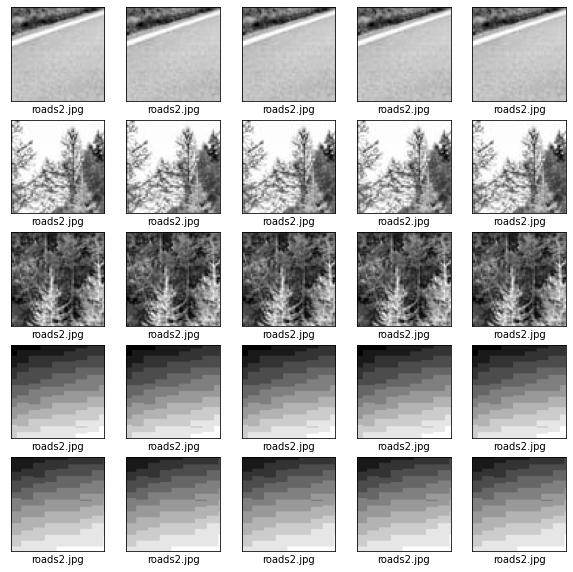

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    src_image = src_patches[i,:,:]
    src_image = np.squeeze(src_image)
    plt.subplot(5,5,i+1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(src_image, cmap='gray')
    plt.xlabel(fnames[i])
plt.show()

Add **Gaussian** **noise** to each patch independently for generating the **input**

In [0]:
noisy_src_patches=[]
noisy_src_patches = src_patches + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=src_patches.shape)
noisy_src_patches = np.clip(noisy_src_patches, 0., 1.)
print(noisy_src_patches.shape )

(7500, 64, 64, 1)


Plot noisy patches

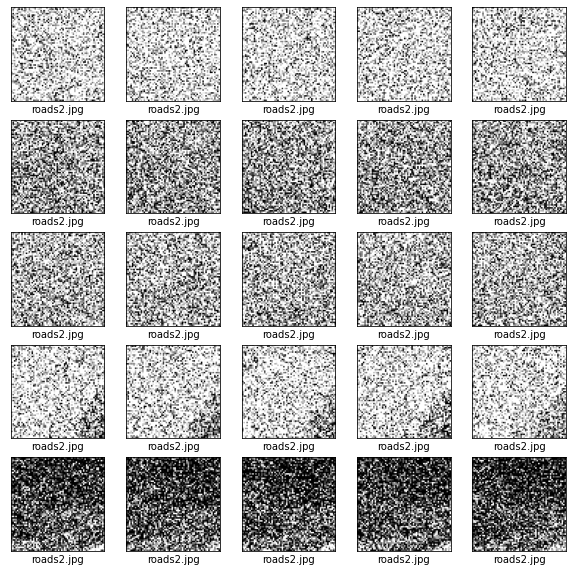

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    noisy_src_image = noisy_src_patches[i,:,:]
    noisy_src_image = np.squeeze(noisy_src_image)
    plt.subplot(5,5,i+1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(noisy_src_image, cmap='gray')
    plt.xlabel(fnames[i])
plt.show()

# Split into training and testing Datasets

In [0]:
# Execute to select randomly train and test
#X_train, X_test, y_train, y_test = train_test_split(noisy_src_patches, src_patches, test_size=0.2, random_state=5) 

In [0]:
split_patches= int(training_portion*(src_patches.shape[0]))
print('Number of train patches: ', split_patches)
print('Number of test patches: ', len(src_patches)-split_patches)


original_train_patches=src_patches[:split_patches, :, :, :]
print('Original train patches: ', original_train_patches.shape)

noisy_train_patches= noisy_src_patches[:split_patches, :, :, :]
print('Noisy train patches: ', noisy_train_patches.shape)

original_test_patches=src_patches[split_patches:, :, :, :]
#print('Original test patches: ', original_test_patches.shape)

noisy_test_patches= noisy_src_patches[split_patches:, :, :, :]
print('Noisy test patches: ',noisy_test_patches.shape)

#Split filenames
train_fnames=fnames[:split_patches]
test_fnames=fnames[split_patches:]

Number of train patches:  6000
Number of test patches:  1500
Original train patches:  (6000, 64, 64, 1)
Noisy train patches:  (6000, 64, 64, 1)
Noisy test patches:  (1500, 64, 64, 1)


We need to reshape the data as we have to feed to a sequence of length 5 to LSTM and have to extract features from sequences usiing Conv Layers.

In [0]:
part_train=int(len(original_train_patches)/seq_len)
part_test=int(len(original_test_patches)/seq_len)


if choose_model=='conv_lstm':
  
    original_train_patches_seq= original_train_patches.reshape(part_train,seq_len,patch_size[0],patch_size[1],1)
    noisy_train_patches_seq= noisy_train_patches.reshape(part_train,seq_len,patch_size[0],patch_size[1],1)

    original_test_patches_seq= original_test_patches.reshape(part_test,seq_len,patch_size[0],patch_size[1],1)
    noisy_test_patches_seq= noisy_test_patches.reshape(part_test,seq_len,patch_size[0],patch_size[1],1)

    output_shape=(1,patch_size[0],patch_size[1],1 )
else:

  original_train_patches_seq= original_train_patches.reshape(part_train,seq_len,patch_size[0]*patch_size[1]*1)
  noisy_train_patches_seq= noisy_train_patches.reshape(part_train,seq_len,patch_size[0]*patch_size[1]*1)

  original_test_patches_seq= original_test_patches.reshape(part_test,seq_len,patch_size[0]*patch_size[1]*1)
  noisy_test_patches_seq= noisy_test_patches.reshape(part_test,seq_len,patch_size[0]*patch_size[1]*1)


# Defining a Sequential Model using LSTM

**Note**: Since we are dealing with image denoising, we have come up with two possible different models:

1. Model with applied CONV layers to extract features  and then applied LSTM.

2. Model with LSTM as encoder and decoder
 LSTM (batch_size, time_steps, num_inputs): in this case we can set the time_steps (sequence_length) to 5 and can provide image as flattened layer of image_width*image_height.




## Defining LSTM Model

In [0]:
units=patch_size[0]*patch_size[1]

def create_lstm_model():    ### Using LSTM only, however this is computationally expensive
    lstm_model = Sequential([
                             
    LSTM(units, input_shape=(seq_len,patch_size[0]*patch_size[1])),

    RepeatVector(seq_len),

    LSTM(units, return_sequences=True),

    TimeDistributed(Dense(units,activation='relu')),
    Dropout(0.2),
    TimeDistributed(Dense(units,activation='linear')),
    ])
    return lstm_model





## Defining conv_lstm model

In [0]:
def create_conv_lstm_model(): 
     
     conv_lstm_model = Sequential([  
                       
       TimeDistributed(
            Conv2D(8, (3,3),padding='same', kernel_initializer='he_normal'), 
            input_shape=(seq_len,patch_size[0], patch_size[1], 1),
                  ),
       TimeDistributed(
           BatchNormalization(),
                 ),
      TimeDistributed(
           Activation("relu"),
                ),
      TimeDistributed(
         MaxPooling2D((2,2))
                ),
 

     TimeDistributed(
          Conv2D(16, (3,3),padding='same',kernel_initializer='he_normal')
                  ),
     TimeDistributed(
         BatchNormalization(),
                 ),
     TimeDistributed(
         Activation("relu"),
               ),             
     TimeDistributed(
        MaxPooling2D((2,2))
                ), 


     TimeDistributed(
             Flatten(),
          ),


    LSTM(units,return_sequences=False),
    Dense(units,activation='relu'),
    Dense(units,activation='sigmoid'),
    Reshape(output_shape)
    ])
     return conv_lstm_model



## Selecting the Model

Here we will use conv+lstm combination since we are dealing  with image denoising.

We are providing 5 sequences of noisy images as output and obtaining clean image at the output.


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_66 (TimeDis (None, 5, 64, 64, 8)      80        
_________________________________________________________________
time_distributed_67 (TimeDis (None, 5, 64, 64, 8)      32        
_________________________________________________________________
time_distributed_68 (TimeDis (None, 5, 64, 64, 8)      0         
_________________________________________________________________
time_distributed_69 (TimeDis (None, 5, 32, 32, 8)      0         
_________________________________________________________________
time_distributed_70 (TimeDis (None, 5, 32, 32, 16)     1168      
_________________________________________________________________
time_distributed_71 (TimeDis (None, 5, 32, 32, 16)     64        
_________________________________________________________________
time_distributed_72 (TimeDis (None, 5, 32, 32, 16)   

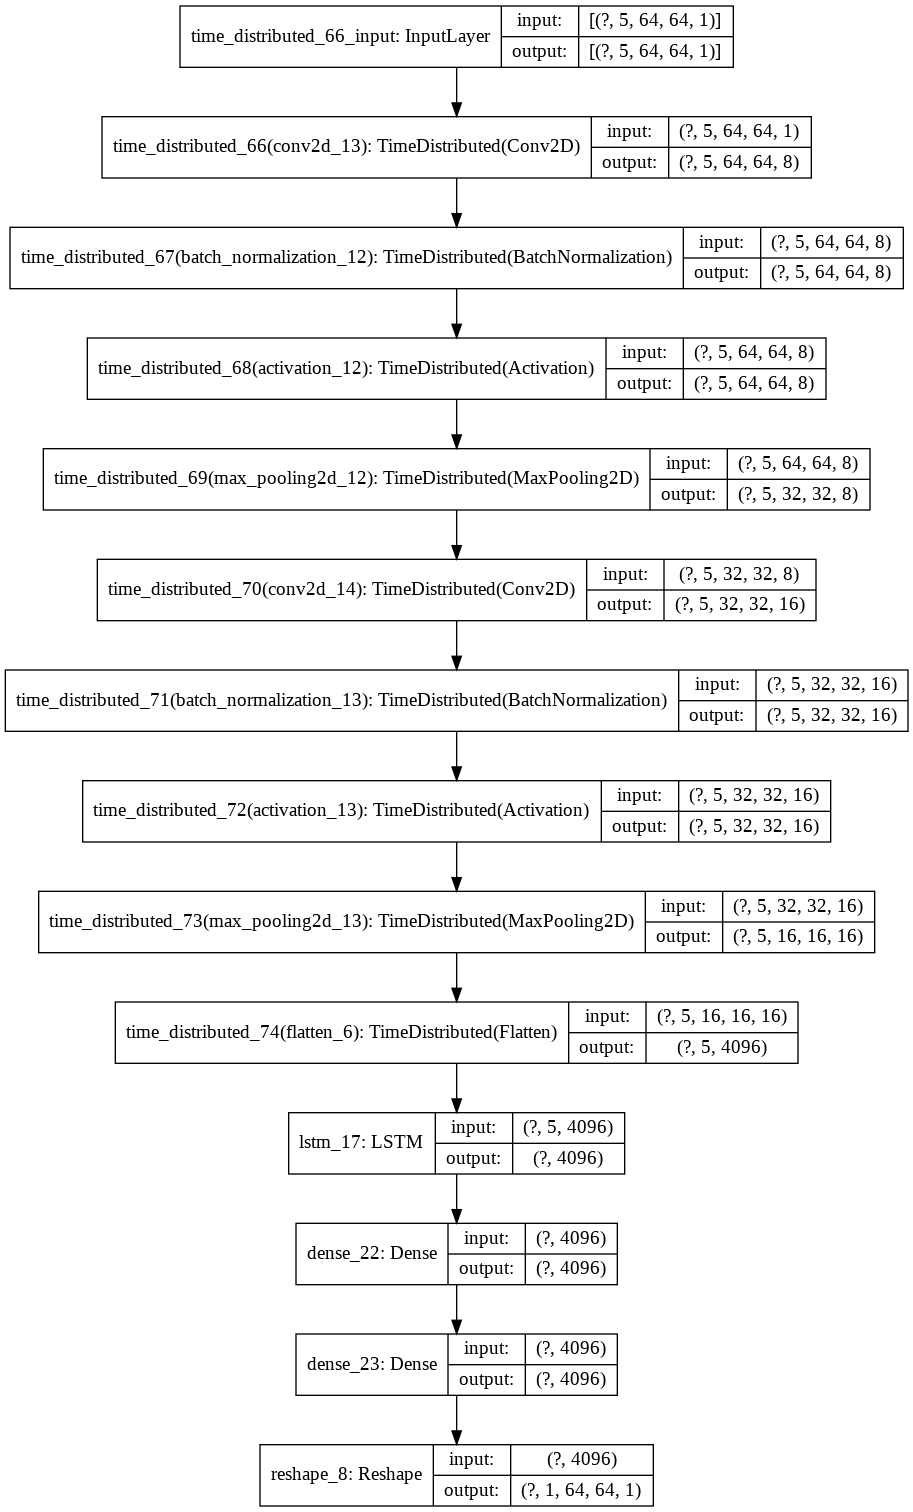

In [0]:
choose_model='conv_lstm'

if choose_model=='lstm':
   model=create_lstm_model()
else:
   model=create_conv_lstm_model()


model.summary()

from tensorflow.keras.utils import  plot_model
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)  #(For debugging)

As can be seen above, we are prceeding with 5 noisy input sequences to LSTM after extracting the features through CONV Layer and at the output we obtaing clean image. 

### Tuning the hyper-parameters

 We do some basic hyper parameter tuning to pick a good learning rate for the gradient descent that will help to improve our model.

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-6)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(noisy_train_patches_seq,
    original_train_patches_seq,
    epochs=num_epochs, validation_split= 0.2,#(noisy_test_patches_seq,original_test_patches_seq),
    batch_size=batch_size,
    callbacks=[lr_schedule], verbose=1)


Text(0.5, 0, 'Learning Rate')

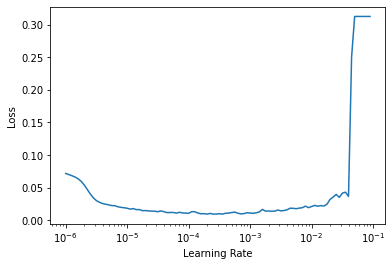

In [0]:
lrs = 1e-6 * (10 ** (np.arange(num_epochs) / 20))
plt.semilogx(lrs, history.history["loss"])
#plt.axis([1e-5,0.9, 0, .2])
plt.ylabel('Loss')
plt.xlabel('Learning Rate')



We can  inspect the lower part of the curve before it gets unstable. We will set the learning rate to be 2e-4 and will compile and train our model in the next steps.


#### Creating checkpoit, compiling  and training the model

In [0]:
if choose_model=='lstm':
   model=create_lstm_model()
else:
  model=create_conv_lstm_model()



# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/tmp/training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights 
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))



optimizer = tf.keras.optimizers.Adam(lr=2e-4)
model.compile(loss="mse", optimizer=optimizer)


# Train the model with the new callback
history = model.fit(noisy_train_patches_seq,
    original_train_patches_seq,
     validation_split=0.2,
     batch_size= batch_size,
    epochs=num_epochs,  callbacks=[cp_callback],verbose=1)

## Evaluate the model

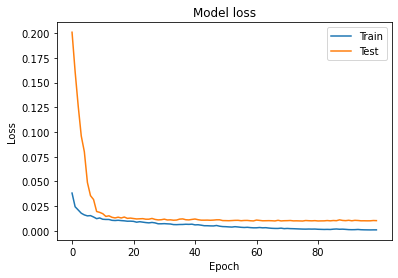

Train Loss: 0.00, Test Loss: 0.01


In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.axis([0,100, 0, 0.09])
plt.xticks(np.arange(0, num_epochs, 20))
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

train_loss = model.evaluate(noisy_train_patches_seq,  original_train_patches_seq,verbose=0)
test_loss = model.evaluate(noisy_test_patches_seq,  original_test_patches_seq,verbose=0)
print('Train Loss: %.2f, Test Loss: %.2f' % (train_loss, test_loss))